In [2]:
import torch
import torchvision
import os
import glob
import time 
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

from src.data import LungDataset, blend, Pad, Crop, Resize
from src.models import UNet, PretrainedUNet
from src.metrics import jaccard, dice
import matplotlib.patches as patches

In [ ]:
data_folder = Path("input", "dataset")
origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"
models_folder = Path("models")
images_folder = Path("images")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)

c:\Users\yaqsc\anaconda3\envs\ST5188\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yaqsc\anaconda3\envs\ST5188\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [7]:
origin_filename = "D:/st5188/data/Curated X-Ray Dataset/Pneumonia-Bacterial"
origin_filenames = glob.glob(os.path.join(origin_filename, "*.jpg"))

save_folder = Path("D:/st5188/data/Curated X-Ray Dataset-Crop/Pneumonia-Bacterial")
save_folder.mkdir(parents=True, exist_ok=True)

print(f"Total files processed: {len(origin_filenames)}")

Total files processed: 3001


In [ ]:

for origin_filename in origin_filenames:
    save_path = save_folder / Path(origin_filename).name
    if save_path.exists():
        #print(f"Skipping {origin_filename}, already processed.")
        continue
    origin = Image.open(origin_filename).convert("P")
    #origin = torchvision.transforms.functional.resize(origin, (512, 512))
    origin = torchvision.transforms.functional.to_tensor(origin) - 0.5
    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
    # 提取非零像素的位置
    nonzero_indices = torch.nonzero(out)

    if nonzero_indices.size(0) == 0:
        #print(f"No non-zero pixels found in {origin_filename}, skipping.")
        original_image = Image.open(origin_filename)
        original_image.save(save_path)
        continue

    # 计算边界框的四角坐标
    min_coords = torch.min(nonzero_indices, dim=0)[0] - 10
    max_coords = torch.max(nonzero_indices, dim=0)[0]+10

    top_left = (min_coords[1].item(), min_coords[0].item())
    top_right = (max_coords[1].item(), min_coords[0].item())
    bottom_left = (min_coords[1].item(), max_coords[0].item())
    bottom_right = (max_coords[1].item(), max_coords[0].item())

    original_image = Image.open(origin_filename)
    # 裁剪图像
    cropped_image = original_image.crop((top_left[0], top_left[1], bottom_right[0], bottom_right[1]))
    # 保存裁剪后的图像
    cropped_image.save(save_path)

In [16]:
origin_filename = "D:/st5188/data/Curated X-Ray Dataset/Normal/Normal (3071).jpg"
origin = Image.open(origin_filename).convert("P")
#origin = torchvision.transforms.functional.resize(origin, (512, 512))
origin = torchvision.transforms.functional.to_tensor(origin) - 0.5

with torch.no_grad():
    origin = torch.stack([origin])
    origin = origin.to(device)
    out = unet(origin)
    softmax = torch.nn.functional.log_softmax(out, dim=1)
    out = torch.argmax(softmax, dim=1)
    
    origin = origin[0].to("cpu")
    out = out[0].to("cpu")

Top-left corner: (363, 42)
Top-right corner: (1846, 42)
Bottom-left corner: (363, 1577)
Bottom-right corner: (1846, 1577)


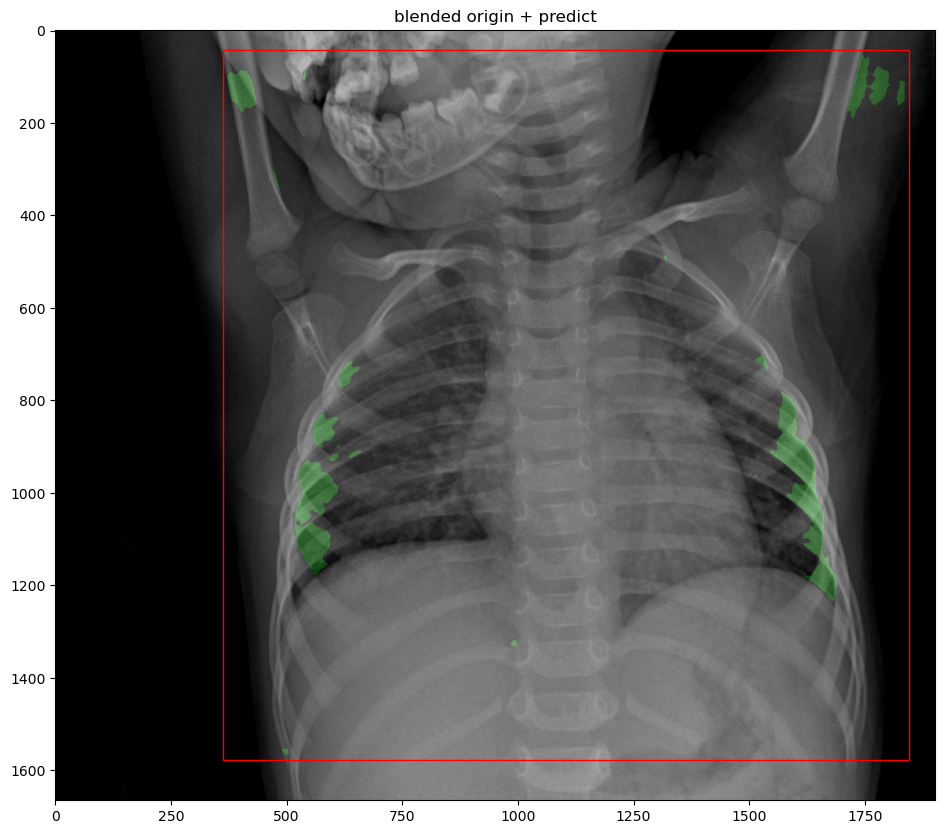

In [17]:
# 提取非零像素的位置
nonzero_indices = torch.nonzero(out)

# 计算边界框的四角坐标
min_coords = torch.min(nonzero_indices, dim=0)[0]-10
max_coords = torch.max(nonzero_indices, dim=0)[0]+10

top_left = (min_coords[1].item(), min_coords[0].item())
top_right = (max_coords[1].item(), min_coords[0].item())
bottom_left = (min_coords[1].item(), max_coords[0].item())
bottom_right = (max_coords[1].item(), max_coords[0].item())

print(f"Top-left corner: {top_left}")
print(f"Top-right corner: {top_right}")
print(f"Bottom-left corner: {bottom_left}")
print(f"Bottom-right corner: {bottom_right}")

plt.figure(figsize=(20, 10))

pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")

# plt.subplot(1, 2, 1)
# plt.title("origin image")
# plt.imshow(np.array(pil_origin))

plt.subplot(1, 1, 1)
plt.title("blended origin + predict")
plt.imshow(np.array(blend(origin, out)))

# 创建一个矩形补丁
rect = patches.Rectangle((top_left[0], bottom_left[1]), max_coords[1].item() - min_coords[1].item(), min_coords[0].item() - max_coords[0].item(), linewidth=1, edgecolor='r', facecolor='none')

# 添加矩形补丁到图中
ax = plt.gca()
ax.add_patch(rect)

plt.show()


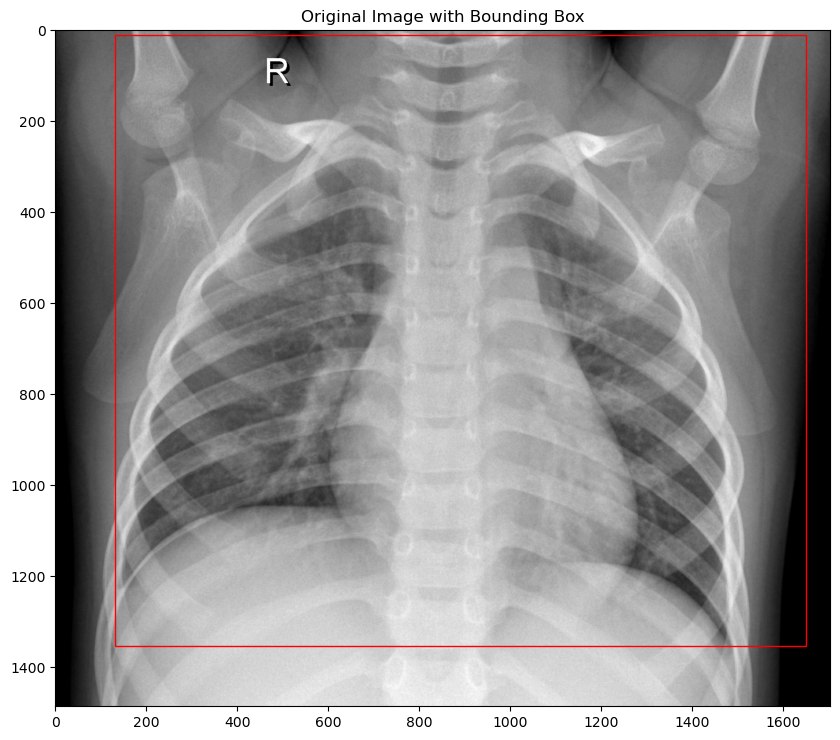

In [17]:
# 打开原始图像
original_image = Image.open(origin_filename)

# 显示原始图像并绘制矩形框
plt.figure(figsize=(10, 10))
plt.title("Original Image with Bounding Box")
plt.imshow(original_image)

# 创建一个矩形补丁
rect = patches.Rectangle((top_left[0], bottom_left[1]), max_coords[1].item() - min_coords[1].item(), min_coords[0].item() - max_coords[0].item(), linewidth=1, edgecolor='r', facecolor='none')

# 添加矩形补丁到图中
ax = plt.gca()
ax.add_patch(rect)

plt.show()


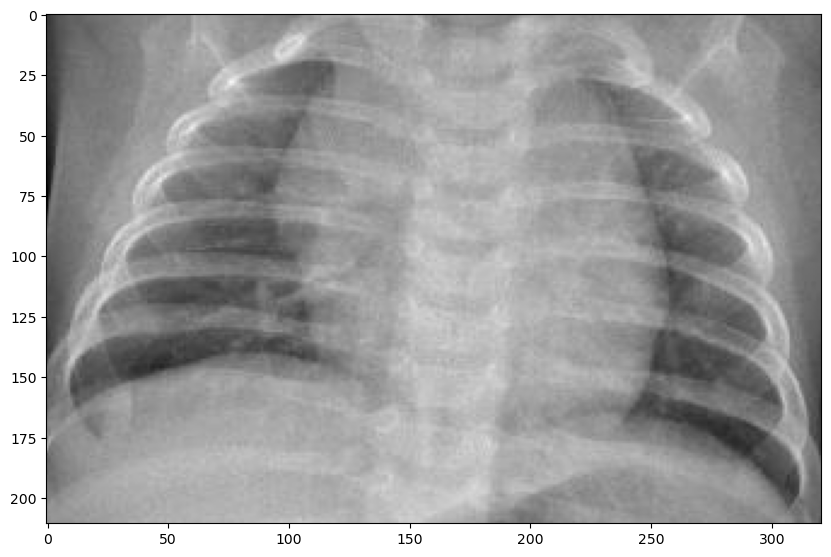

In [14]:
# 定义保存路径
# save_folder = Path("D:/st5188/data/Curated X-Ray Dataset-Crop/Normal")
# save_folder.mkdir(parents=True, exist_ok=True)

# 裁剪图像
cropped_image = original_image.crop((top_left[0], top_left[1], bottom_right[0], bottom_right[1]))

# 显示原始图像并绘制矩形框
plt.figure(figsize=(10, 10))
plt.imshow(cropped_image)

# 保存裁剪后的图像
# cropped_image.save(save_folder / Path(origin_filename).name)